# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import json
import requests
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten, Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [65]:
# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
# hist = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# hist.head()

hist = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')
hist.head()

,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
0,0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0
1,1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0
2,2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0
3,3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0
4,4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0


In [66]:
#hist = hist.drop(['high','low','open','volumefrom','volumeto'], axis=1)
#hist = hist.drop(['Unix Timestamp','Date','Symbol','Open','High','Low','Volume'], axis=1)
#hist = hist.drop(['Date','Symbol','Unix Timestamp','Low','High'], axis=1)
hist = hist.drop(['Date','Symbol','Popularity','Volume BTC','Volume USD'], axis=1)
hist = hist.drop('Unnamed: 0', axis=1)
hist.tail()

,Open,High,Low,Close,Popularity_Normalized
1803,494.77,530.00,494.77,530.00,200.0
1804,493.43,497.67,490.85,494.77,200.0
1805,445.56,498.84,445.56,493.43,200.0
1806,445.56,445.56,445.56,445.56,200.0
1807,453.83,453.83,445.56,445.56,200.0


In [67]:
print(len(hist))

1808


In [68]:
print("checking if any null values are present\n", hist.isna().sum())

checking if any null values are present
 Open                     0
High                     0
Low                      0
Close                    0
Popularity_Normalized    0
dtype: int64


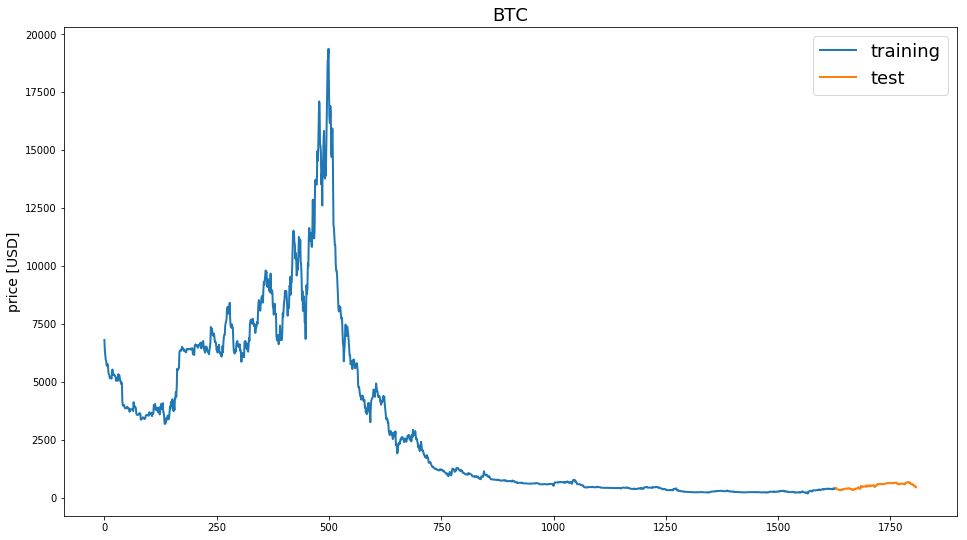

In [69]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.Close, test.Close, 'training', 'test', 'BTC')

In [70]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.Close[window:].values
    y_test = test_data.Close[window:].values
    if zero_base:
        y_train = y_train / train_data.Close[:-window].values - 1
        y_test = y_test / test_data.Close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [71]:
print(X_train.shape)
print(X_train.shape)
print(y_test.shape)
print(y_test.shape)

(1621, 7, 5)
(1621, 7, 5)
(173,)
(173,)


In [72]:
TIME_STEPS = 7
BATCH_SIZE_OUT = 4 # 16 was better
LR = 0.005
# epochs = 150
EPOCHS = 50

In [74]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
#     generator = Sequential()
#     #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
#     # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
#     generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True)) 
#     generator.add(Dense(8,activation='relu'))
#     generator.add(Dropout(0.7))
#     generator.add(LSTM(8, return_sequences=False))
#     generator.add(Dense(1,activation='sigmoid'))
#     #generator.add(Reshape((TIME_STEPS, 1)))
#     optimizer = RMSprop(lr=LR, decay=3e-8)
#     #generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#     generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 5), return_sequences=False))
    generator.add(LeakyReLU(0.5))
    generator.add(Dropout(0.5))
    generator.add(Dense(5))
    generator.add(Activation('tanh'))
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    generator.compile(loss='mean_squared_error', optimizer=optimizer)

    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (4, 16)                   1408      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (4, 16)                   0         
_________________________________________________________________
dropout_27 (Dropout)         (4, 16)                   0         
_________________________________________________________________
dense_35 (Dense)             (4, 5)                    85        
_________________________________________________________________
activation_11 (Activation)   (4, 5)                    0         
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


In [75]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=16, batch_input_shape=(8, TIME_STEPS, 5)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
       
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=8))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    discriminator.compile(loss='mean_squared_error', optimizer=optimizer)

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (8, 7, 16)                96        
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (8, 7, 16)                0         
_________________________________________________________________
dropout_28 (Dropout)         (8, 7, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (8, 7, 8)                 136       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (8, 7, 8)                 0         
_________________________________________________________________
dropout_29 (Dropout)         (8, 7, 8)                 0         
_________________________________________________________________
dense_38 (Dense)             (8, 7, 1)                 9         
Total para

In [76]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 5)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    #gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    gan.compile(loss='mean_squared_error', optimizer=optimizer)
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 7, 5)              0         
_________________________________________________________________
sequential_19 (Sequential)   multiple                  1493      
_________________________________________________________________
sequential_20 (Sequential)   multiple                  241       
Total params: 1,734
Trainable params: 1,493
Non-trainable params: 241
_________________________________________________________________


In [77]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
#(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan

    global X_train
    global X_test
    global y_train
    global y_test
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            #print(X_train.shape)
            
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=BATCH_SIZE_OUT)]
            
            
            dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_0 = generated_prices.shape[0]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 5))
            
            for j in range(dim_0):
                gen_prices[j] = generated_prices[j]
            

#             print('Shapes 1')
#             print(noise.shape)
#             print(prices_batch.shape)
#             print(generated_prices.shape)     
#             print(gen_prices.shape)
#             print('>>>>>>>>>>>gen_prices>>>>>>>')            
#             print(gen_prices)
#             print(prices_batch)
#             #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, 1))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
#             print('Shapes 2')
#             print(X.shape)
#             print(y_dis.shape)
#             print('>>>>>>>>>>>x>>>>>>>')
#             print(X)
#             print('>>>>>>>>>>>y_dis>>>>>>>')            
#             print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
#             print('Shapes 3')
#             print(noise.shape)
#             print(y_gen.shape)
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                #log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                #log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                log_mesg = "%d: [D loss: %f]" % (e, d_loss)
                log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
#         if e == 1 or e % 5 == 0:
#             # generate synthetic dataset
#             gen_samples_set = []
#             for batch_idx in range(int(len(X_train) / batch_size)):
#             # for batch_idx in range(int(len(X_train) / 100)):
#                 # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
#                 #noise= np.random.normal(0,1, [batch_size, 8])
#                 noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
#                 generated_data = generator.predict(noise)
#                 gen_samples_set.append(generated_data)

#             gen_samples = np.vstack(gen_samples_set)

In [78]:
#training(400,128)
training(50,12)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/12 [00:00<?, ?it/s]

1: [D loss: 0.204102]  [A loss: 0.297778]
Epoch 2
2: [D loss: 0.205888]  [A loss: 0.253588]
Epoch 3


  0%|          | 0/12 [00:00<?, ?it/s]

3: [D loss: 0.201275]  [A loss: 0.269838]
Epoch 4
4: [D loss: 0.203540]  [A loss: 0.262375]
Epoch 5


  0%|          | 0/12 [00:00<?, ?it/s]

5: [D loss: 0.200510]  [A loss: 0.238563]
Epoch 6
6: [D loss: 0.206585]  [A loss: 0.286418]
Epoch 7


  0%|          | 0/12 [00:00<?, ?it/s]

7: [D loss: 0.205573]  [A loss: 0.257265]
Epoch 8
8: [D loss: 0.202487]  [A loss: 0.245031]
Epoch 9


 50%|█████     | 6/12 [00:00<00:00, 53.03it/s]

9: [D loss: 0.200556]  [A loss: 0.460930]
Epoch 10


 42%|████▏     | 5/12 [00:00<00:00, 47.11it/s]

10: [D loss: 0.200551]  [A loss: 0.279817]
Epoch 11


 50%|█████     | 6/12 [00:00<00:00, 52.88it/s]

11: [D loss: 0.202805]  [A loss: 0.272116]
Epoch 12


  0%|          | 0/12 [00:00<?, ?it/s]

12: [D loss: 0.206315]  [A loss: 0.264514]
Epoch 13
13: [D loss: 0.209857]  [A loss: 0.318276]
Epoch 14


  0%|          | 0/12 [00:00<?, ?it/s]

14: [D loss: 0.194729]  [A loss: 0.305138]
Epoch 15
15: [D loss: 0.203480]  [A loss: 0.260694]
Epoch 16


 50%|█████     | 6/12 [00:00<00:00, 51.39it/s]

16: [D loss: 0.209773]  [A loss: 0.266671]
Epoch 17


 42%|████▏     | 5/12 [00:00<00:00, 48.85it/s]

17: [D loss: 0.196197]  [A loss: 0.290348]
Epoch 18


 42%|████▏     | 5/12 [00:00<00:00, 46.39it/s]

18: [D loss: 0.220195]  [A loss: 0.278889]
Epoch 19


  0%|          | 0/12 [00:00<?, ?it/s]

19: [D loss: 0.202409]  [A loss: 0.270295]
Epoch 20
20: [D loss: 0.205042]  [A loss: 0.346197]
Epoch 21


 50%|█████     | 6/12 [00:00<00:00, 52.49it/s]

21: [D loss: 0.193440]  [A loss: 0.319114]
Epoch 22


  0%|          | 0/12 [00:00<?, ?it/s]

22: [D loss: 0.188754]  [A loss: 0.278172]
Epoch 23
23: [D loss: 0.206895]  [A loss: 0.289806]
Epoch 24


 50%|█████     | 6/12 [00:00<00:00, 52.22it/s]

24: [D loss: 0.200589]  [A loss: 0.346173]
Epoch 25


  0%|          | 0/12 [00:00<?, ?it/s]

25: [D loss: 0.205578]  [A loss: 0.277750]
Epoch 26
26: [D loss: 0.188658]  [A loss: 0.289953]
Epoch 27


 50%|█████     | 6/12 [00:00<00:00, 53.62it/s]

27: [D loss: 0.199449]  [A loss: 0.255651]
Epoch 28


 17%|█▋        | 2/12 [00:00<00:00, 18.10it/s]

28: [D loss: 0.189419]  [A loss: 0.272171]
Epoch 29


  0%|          | 0/12 [00:00<?, ?it/s]

29: [D loss: 0.206951]  [A loss: 0.334856]
Epoch 30
30: [D loss: 0.193317]  [A loss: 0.296380]
Epoch 31


  0%|          | 0/12 [00:00<?, ?it/s]

31: [D loss: 0.196327]  [A loss: 0.276817]
Epoch 32
32: [D loss: 0.206447]  [A loss: 0.286470]
Epoch 33


 50%|█████     | 6/12 [00:00<00:00, 54.36it/s]

33: [D loss: 0.206719]  [A loss: 0.276873]
Epoch 34


 42%|████▏     | 5/12 [00:00<00:00, 43.62it/s]

34: [D loss: 0.201128]  [A loss: 0.286584]
Epoch 35


  0%|          | 0/12 [00:00<?, ?it/s]

35: [D loss: 0.200928]  [A loss: 0.321949]
Epoch 36
36: [D loss: 0.200052]  [A loss: 0.283142]
Epoch 37


  0%|          | 0/12 [00:00<?, ?it/s]

37: [D loss: 0.194259]  [A loss: 0.285164]
Epoch 38
38: [D loss: 0.202406]  [A loss: 0.244226]
Epoch 39


 50%|█████     | 6/12 [00:00<00:00, 54.71it/s]

39: [D loss: 0.206047]  [A loss: 0.313897]
Epoch 40
40: [D loss: 0.200267]  [A loss: 0.277370]


100%|██████████| 12/12 [00:00<00:00, 62.18it/s]


Epoch 41
41: [D loss: 0.202999]  [A loss: 0.327858]
Epoch 42


  0%|          | 0/12 [00:00<?, ?it/s]

42: [D loss: 0.197716]  [A loss: 0.287508]
Epoch 43
43: [D loss: 0.200956]  [A loss: 0.285030]
Epoch 44


 42%|████▏     | 5/12 [00:00<00:00, 43.94it/s]

44: [D loss: 0.199959]  [A loss: 0.294614]
Epoch 45


  0%|          | 0/12 [00:00<?, ?it/s]

45: [D loss: 0.201119]  [A loss: 0.239788]
Epoch 46
46: [D loss: 0.194270]  [A loss: 0.310650]
Epoch 47


  0%|          | 0/12 [00:00<?, ?it/s]

47: [D loss: 0.197343]  [A loss: 0.294092]
Epoch 48
48: [D loss: 0.198386]  [A loss: 0.269152]
Epoch 49


100%|██████████| 12/12 [00:00<00:00, 83.88it/s]

49: [D loss: 0.209909]  [A loss: 0.295936]
Epoch 50
50: [D loss: 0.200417]  [A loss: 0.279291]


Text(0,0.5,'Loss')

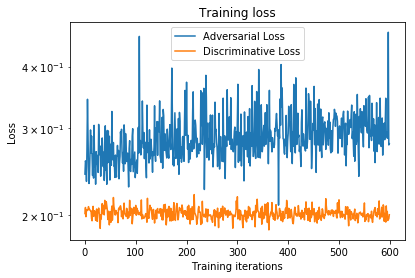

In [79]:
# adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
# discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss,
        'Discriminative Loss': discrimator_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

In [80]:
targets = test.Close[7:]
preds = gan.predict(X_test).squeeze()

In [81]:
# Should look at other metrics as well (MSE, RMSE, Accuracy)
metrics.mean_absolute_error(preds, y_test)

0.44181575456653355

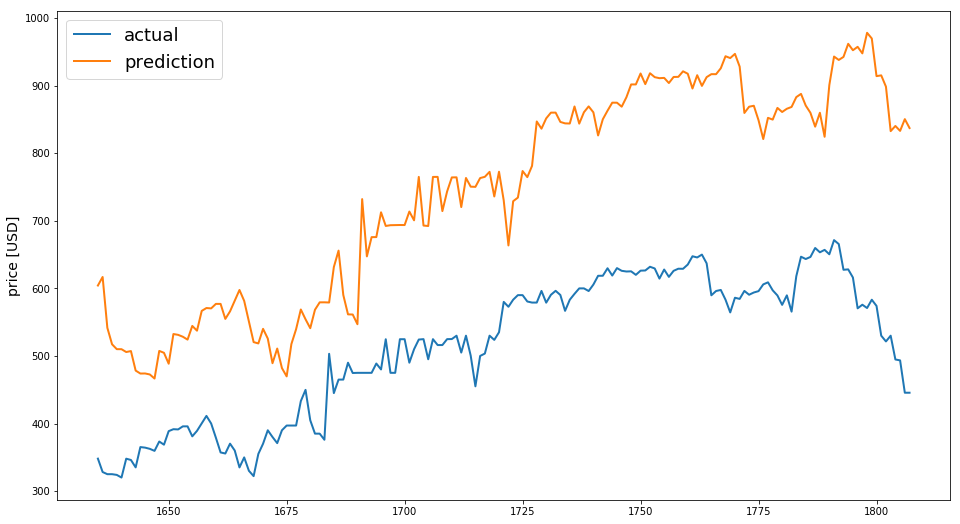

In [82]:
preds = test.Close.values[:-7] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction')

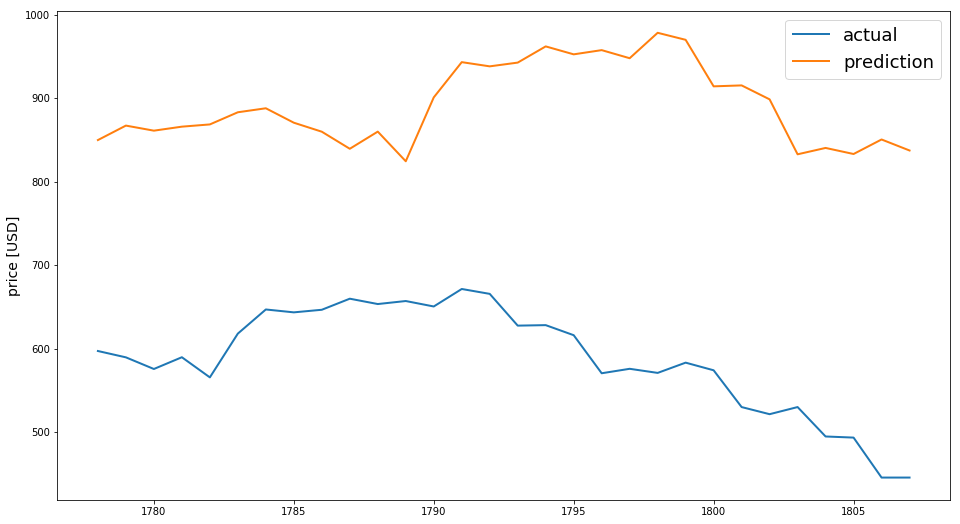

In [86]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction')